In [1]:
import escape_time_threshold as ETT
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import colors 
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import sys 
sys.path.append("../../code/")
import StreamOrbitCoords as SOC
import data_extractors as DE
sys.path.append("../../analysis/")
import plotters

In [12]:
def set_up_gridspec():
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(4, 2, width_ratios=[1, 0.01], height_ratios=[1,1,1,1])
    ax0= plt.subplot(gs[0, 0])
    ax1= plt.subplot(gs[1, 0])
    ax2= plt.subplot(gs[2, 0])
    ax3= plt.subplot(gs[3, 0])
    caxis = plt.subplot(gs[2:4, 1])

    return fig, ax0, ax1, ax2, ax3, caxis

In [3]:
config = {
    "montecarlokey": "monte-carlo-009",
    "GCname": "Pal5",
    "MWpotential": "pouliasis2017pii-GCNBody",
    "NP": int(1e5),
    "outdir":"/scratch2/sferrone/plots/stream_analysis/questions/initial-escapers-distributions/",
    "factor_min": 1,
    "factor_max":30000,
    "nskip": 1000
}

In [4]:
stream_path     = "/scratch2/sferrone/simulations/Streams/"+config["MWpotential"]+"/"+config["GCname"]+"/"+str(config["NP"])+"/"
stream_filename = config["GCname"] + "-streams-" + config['montecarlokey'] + ".hdf5"
orbit_path      = "/scratch2/sferrone/simulations/Orbits/"+config["MWpotential"]+"/"+config["GCname"]+"-orbits.hdf5"    


In [5]:
# load orbit 
time_of_interest=0
filtertime=0.3
thost,xhost,yhost,zhost,vxhost,vyhost,vzhost=DE.get_orbit(orbit_path,config['montecarlokey'])
current_index = np.argmin(np.abs(thost-time_of_interest))
thost,xhost,yhost,zhost,vxhost,vyhost,vzhost=DE.filter_orbit_by_fixed_time(thost,(xhost,yhost,zhost,vxhost,vyhost,vzhost),current_index,filtertime)

In [6]:
# load stream
tesc,x,y,z,vx,vy,vz = ETT.load_stream(stream_path+stream_filename,config)

In [7]:
# convert to tail coordiantes
galactic_coordinates=(x,y,z,vx,vy,vz)
orbit_galactic_coordinates=(thost,xhost,yhost,zhost,vxhost,vyhost,vzhost)
time_coordinate,tail_coordinates=DE.convert_instant_to_tail_coordinates(galactic_coordinates,orbit_galactic_coordinates,time_of_interest)

In [8]:
threshold=-5
cond = tesc <= threshold

In [9]:
# make density distribution, twice!
xmax,ymax=10,0.5
NP=int(1e5)
xedges,yedges=plotters.histogramEdges(NP//1,xmax,ymax)
X_new,Y_new,H_new=plotters.getHistogram2d(tail_coordinates[0][cond],tail_coordinates[1][cond],xedges,yedges)
X_old,Y_old,H_old=plotters.getHistogram2d(tail_coordinates[0][~cond],tail_coordinates[1][~cond],xedges,yedges)
H_old/=NP
H_new/=NP

In [10]:
### PREPARE THE PLOT
norm_density = colors.LogNorm(vmin=1e-5, vmax=4e-4)
cmap_density = plt.cm.rainbow
### PREPARE PLOT 
tesc_escape_only = tesc[tesc <=0]
nbins = int(np.ceil(np.sqrt(config["NP"])))
counts,edges = np.histogram(tesc_escape_only,bins=nbins)
centers = (edges[:-1] + edges[1:]) / 2

In [29]:
bigFont = 18
smallfont=14
plt.rcParams['axes.titlesize'] = bigFont  # For the title
plt.rcParams['axes.labelsize'] = bigFont  # For the x and y labels
plt.rcParams['xtick.labelsize'] = smallfont  # For the x tick labels
plt.rcParams['ytick.labelsize'] = smallfont  # For the y tick labels
plt.rcParams['legend.fontsize'] = smallfont  # For the legend

In [37]:
def fill_in_figure(fig, ax0, ax1, ax2, ax3, caxis, threshold, tail_coordinates, tesc_escape_only, counts, edges, centers, cmap_density, norm_density, bigFont):
    ax0.scatter(tail_coordinates[0][cond],tail_coordinates[1][cond], c="r", s=1, alpha=0.5,);
    ax0.scatter(tail_coordinates[0][~cond],tail_coordinates[1][~cond], c="w", s=1,alpha=0.5);
    # Create custom markers
    custom_markers = [Line2D([0], [0], color='r', marker='o', linestyle='', markersize=10),  # Adjust markersize as needed
                    Line2D([0], [0], color='w', marker='o', linestyle='', markersize=10)]  # Adjust markersize as needed

    # Create the legend with custom markers
    ax0.legend(custom_markers, ["t_esc < {:.2f}".format(threshold), "t_esc > {:.2f}".format(threshold)])
    ax1.set_xlim(tesc_escape_only.min(), -3);


    for i in range(len(counts)):
        if centers[i] < threshold:
            color = "r"
        else:
            color = "w"
        ax1.bar(centers[i], counts[i], width=(edges[i+1] - edges[i]), color=color, edgecolor='black', )
    ax1.set_xlabel('Escape Time [s kpc / km]');
    ax1.set_ylabel('N');
    ax1.set_yscale('log');
    ax1.set_xlim(tesc_escape_only.min(), 0);
    ylims = ax1.get_ylim()
    ax1.vlines(threshold, ylims[0], ylims[1], color='r', linestyle='--', label='Threshold');
    ax1.set_ylim(ylims);
    word = "Threshold: {:.2f}".format(threshold)
    ax1.text(threshold, 0.6*ylims[1], word, ha='left', va='top', color='r',size=15);



    for ax in [ax0,ax2,ax3]:
        ax.set_xlim(-10,10);
        ax.set_ylim(-0.5,0.5);
    ax0.set_ylabel("y' [kpc]");
    ax2.set_ylabel("y' [kpc]");
    ax3.set_ylabel("y' [kpc]");
    ax3.set_xlabel("x' [kpc]");
    ax0.set_xlabel("x' [kpc]");


    sc0=ax2.scatter(X_old,Y_old,c=H_old, s=1, cmap=cmap_density, norm=norm_density);
    ax3.scatter(X_new,Y_new,c=H_new, s=1, cmap=cmap_density, norm=norm_density);

    cbar = fig.colorbar(sc0, cax=caxis)
    cbar.set_label(r'$\Sigma$',fontsize=bigFont)
    
    fig.tight_layout()
    return fig, ax0, ax1, ax2, ax3, caxis

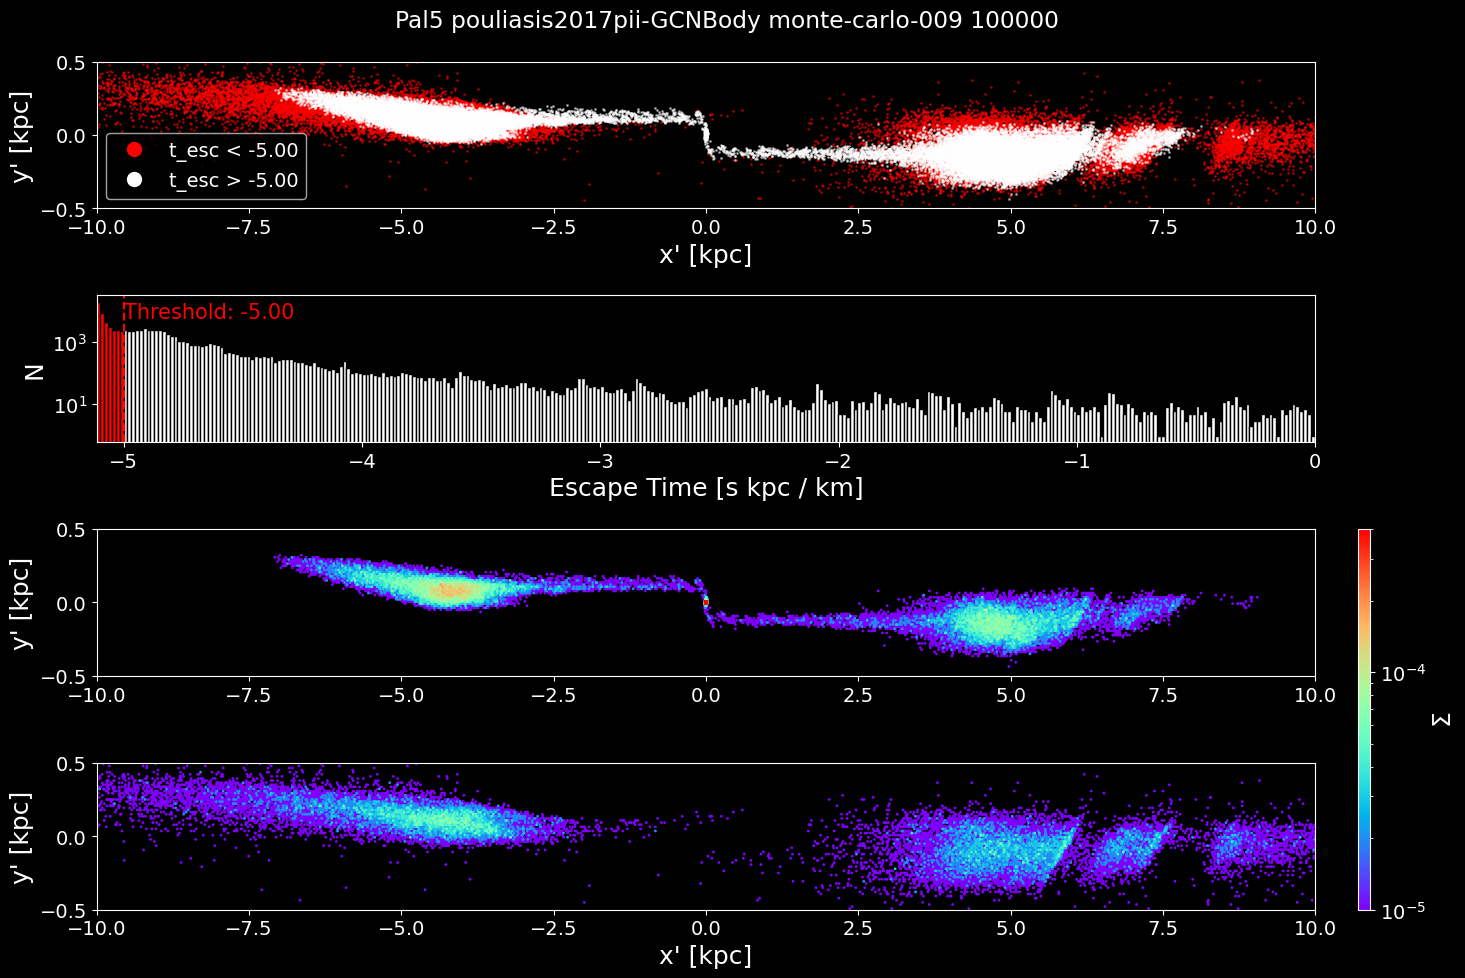

In [39]:
fig, ax0, ax1, ax2, ax3, caxis = set_up_gridspec() # type: ignore
fig, ax0, ax1, ax2, ax3, caxis = fill_in_figure(fig, ax0, ax1, ax2, ax3, caxis, threshold, tail_coordinates, tesc_escape_only, counts, edges, centers, cmap_density, norm_density, bigFont)
title = "{:s} {:s} {:s} {:d}".format(config['GCname'],config["MWpotential"],config['montecarlokey'],config['NP'])
outname = "TC-{:s}-{:.4f}".format(config["GCname"],threshold)
fig.suptitle(title)
fig.tight_layout()

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colors 
import numpy as np
import h5py
from astropy import units as u

The stream is artifically thick, is this because of using a plummer for Palomar 5 was a poor model choice?
Let us investigate 


In [2]:
config = {
    "montecarlokey": "monte-carlo-000",
    "GCname": "Pal5",
    "MWpotential": "pouliasis2017pii",
    "NP": int(1e5),
}

In [3]:
stream_path     = "/scratch2/sferrone/simulations/Streams/"+config["MWpotential"]+"/"+config["GCname"]+"/"+str(config["NP"])+"/"
stream_filename = config["GCname"] + "-streams-" + config['montecarlokey'] + ".hdf5"

In [4]:
mystream = h5py.File(stream_path+stream_filename, 'r')

In [5]:
tesc=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['tesc'][:]
x=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['x'][:]
y=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['y'][:]
z=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['z'][:]
vx=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['vx'][:]
vy=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['vy'][:]
vz=mystream['isotropic-plummer'][str(config['NP'])][config['montecarlokey']]['vz'][:]

## Change the non escaped particles to positive times
tesc[tesc==tesc.min()]=999

In [6]:
dt = 1e4*u.yr
dt=dt.to(u.s*u.kpc/u.km).value
threshold = tesc.min() + 30000*dt
cond = tesc < threshold

In [8]:
norm = colors.Normalize(vmin=tesc.min(), vmax=0)
cmap = plt.cm.rainbow

In [9]:
nbins = int(np.ceil(np.sqrt(config["NP"])))
tesc_escape_only = tesc[tesc <=0]

In [10]:
plt.style.use("dark_background")


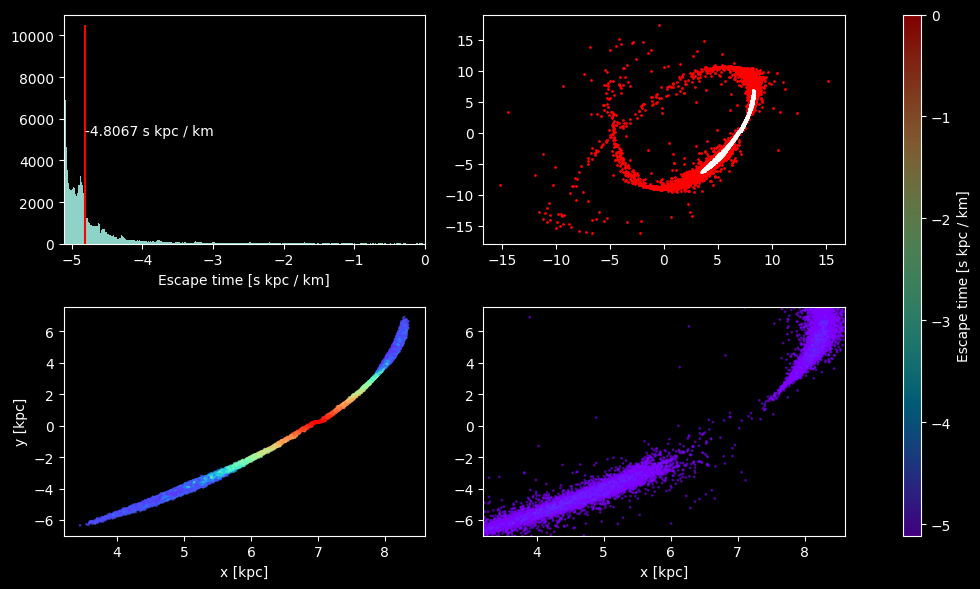

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(10, 6))
# Define GridSpec layout
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], height_ratios=[1, 1])
# Top row, one long plot
ax0 = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[0, 0])
# Bottom row, two axes of similar size
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
# Third column, skinny plot for colorbar
ax4 = fig.add_subplot(gs[:, 2])




### The top plot 
ax1.hist(tesc_escape_only,bins=nbins)
ax1.set_xlim(tesc.min(),0)
ylims=ax1.get_ylim()
ax1.vlines(threshold,ylims[0],ylims[1],colors='r',)
words = "{:.4f} s kpc / km".format(threshold)
ax1.text(threshold,ylims[1]//2,words)

ax0.scatter(x[cond],y[cond],s=1,color="r")
ax0.scatter(x[~cond],y[~cond],s=1,color="w")


## the middle plots 
sc0 = ax2.scatter(x[~cond],y[~cond],c=tesc[~cond],cmap=cmap,norm=norm,s=1,alpha=0.5)
sc1 = ax3.scatter(x[cond],y[cond],c=tesc[cond],cmap=cmap,norm=norm,s=1,alpha=0.5)
cbar = fig.colorbar(sc0, cax=ax4)
cbar.set_label('Escape time [s kpc / km]')
ax1.set_xlabel('Escape time [s kpc / km]')


xlims,ylims=ax2.get_xlim(),ax2.get_ylim()

ax3.set_xlim(xlims)
ax3.set_ylim(ylims)

ax2.set_ylabel('y [kpc]')
ax2.set_xlabel('x [kpc]')
ax3.set_xlabel('x [kpc]')
fig.tight_layout()


In [1]:
import escape_time_threshold as ETT

In [2]:
config = {
    "montecarlokey": "monte-carlo-000",
    "GCname": "Pal5",
    "MWpotential": "pouliasis2017pii",
    "NP": int(1e5),
}


In [3]:
factor_step = 10
# load data
stream_path     = "/scratch2/sferrone/simulations/Streams/"+config["MWpotential"]+"/"+config["GCname"]+"/"+str(config["NP"])+"/"
stream_filename = config["GCname"] + "-streams-" + config['montecarlokey'] + ".hdf5"

In [15]:
import h5py
observablespath="/scratch2/sferrone/simulations/MonteCarloObservables/"
fname = observablespath+"NGC3201"+"-observables.hdf5"
myfile = h5py.File(fname,"r")
masses = [ ]
mcarlokeys= []
for i in range(50):
    mcarlokey = "monte-carlo-"+str(i).zfill(3)
    
    masses.append(myfile[mcarlokey]['Mass'][0])
    mcarlokeys.append(mcarlokey)

In [16]:
print(masses[np.argmin(masses)],masses[np.argmax(masses)])
print(mcarlokeys[np.argmin(masses)],mcarlokeys[np.argmax(masses)])

185058.6311978104 200615.5602560136
monte-carlo-041 monte-carlo-037
